Author: Nik Alleyne
Author Blog: https://www.securitynik.com
Author GitHub: github.com/securitynik

Author Books: [

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/", 

            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/" 
        ] 

Before digging any deeper, I must state, this notebook/post heavily leverages the work done by Joe Petroske on "Hunting Beacon Activity with Fourier Transforms" along with his notebook on GitHub at https://github.com/target/Threat-Hunting/blob/master/Beacon%20Hunting/find_beacons_by_fourier.ipynb. 

More importantly, it ties together what we teach in the SANS SEC595: Applied Data Science and AI/Machine Learning for Cybersecurity Professionals as a relates to leveraging Fourier Analysis to find beacons: https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/

While as mentioned above, this notebook/post will leverage the above content heavily, we will move this from a problem to a solution. Meaning, we will start from scratch and then implement the solution, once again, based heavily on Joe's code. This way, when you are about to implement this in your environment, you are clear on how you can solve your problems.

Some other references used:
https://realpython.com/python-scipy-fft/
https://towardsdatascience.com/fourier-transform-the-practical-python-implementation-acdd32f1b96a
https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.00-Fourier-Transforms.html

## Issue/Problem/Concern:

One day, while capturing some packets for an unrelated issue, I saw the following:

securitynik@peeper:~$ sudo tcpdump -n --interface 2 '(port 53) and not (host 127.0.0.1)' -c 10  
tcpdump: verbose output suppressed, use -v[v]... for full protocol decode  
listening on any, link-type EN10MB (Ethernet), snapshot length 262144 bytes  
18:39:24.124355 IP 10.0.0.9.46088 > 10.0.0.2.53: 40639+ A? somedomain.securitynik.local. (44)  
18:39:24.124604 IP 10.0.0.2.53 > 10.0.0.9.46088: 40639 4/0/0 CNAME somedomain.ca.securitynik.local., CNAME   securitynik-something.us-east-1.elb.amazonaws.com., A 172.16.16.55, A 172.16.16.211 (203)  
18:39:26.134773 IP 10.0.0.9.50992 > 10.0.0.2.53: 40640+ A? somedomain.securitynik.local. (44)  
18:39:26.135072 IP 10.0.0.2.53 > 10.0.0.9.50992: 40640 4/0/0 CNAME somedomain.ca.securitynik.local., CNAME     securitynik-something.us-east-1.elb.amazonaws.com., A 172.16.16.211, A 172.16.16.55 (203)  
18:39:28.144568 IP 10.0.0.9.49995 > 10.0.0.2.53: 40641+ A? somedomain.securitynik.local. (44)  
18:39:28.144829 IP 10.0.0.2.53 > 10.0.0.9.49995: 40641 4/0/0 CNAME somedomain.ca.securitynik.local., CNAME   securitynik-something.us-east-1.elb.amazonaws.com., A 172.16.16.55, A 172.16.16.211 (203)  
18:39:29.172416 IP 10.0.0.32.41636 > 10.0.0.2.53: 2+ A? pool.ntp.org. (30)  
18:39:29.181785 IP 10.0.0.2.53 > 10.0.0.32.41636: 2 4/0/0 A 162.159.200.123, A 137.220.55.232, A 217.180.209.214, A 209.115.181.107 (94)
...


### Did you see anything interesting?  

I doubt whether at first glance, you see what the issue is. Do you see the issue now that I have highlighted the time below?

securitynik@peeper:~$ sudo tcpdump -n --interface 2 '(port 53) and not (host 127.0.0.1)' -c 10  
tcpdump: verbose output suppressed, use -v[v]... for full protocol decode  
listening on any, link-type EN10MB (Ethernet), snapshot length 262144 bytes  
**18:39:24**.124355 IP 10.0.0.9.46088 > 10.0.0.2.53: 40639+ A? somedomain.securitynik.local. (44)  
**18:39:24**.124604 IP 10.0.0.2.53 > 10.0.0.9.46088: 40639 4/0/0 CNAME somedomain.ca.securitynik.local., CNAME   securitynik-something.us-east-1.elb.amazonaws.com., A 172.16.16.55, A 172.16.16.211 (203)  
**18:39:26**.134773 IP 10.0.0.9.50992 > 10.0.0.2.53: 40640+ A? somedomain.securitynik.local. (44)  
**18:39:26**.135072 IP 10.0.0.2.53 > 10.0.0.9.50992: 40640 4/0/0 CNAME somedomain.ca.securitynik.local., CNAME   securitynik-something.us-east-1.elb.amazonaws.com., A 172.16.16.211, A 172.16.16.55 (203)  
**18:39:28**.144568 IP 10.0.0.9.49995 > 10.0.0.2.53: 40641+ A? somedomain.securitynik.local. (44)  
**18:39:28**.144829 IP 10.0.0.2.53 > 10.0.0.9.49995: 40641 4/0/0 CNAME somedomain.ca.securitynik.local., CNAME   securitynik-something.us-east-1.elb.amazonaws.com., A 172.16.16.55, A 172.16.16.211 (203)  
18:39:29.172416 IP 10.0.0.32.41636 > 10.0.0.2.53: 2+ A? pool.ntp.org. (30)  
18:39:29.181785 IP 10.0.0.2.53 > 10.0.0.32.41636: 2 4/0/0 A 162.159.200.123, A 137.220.55.232, A 217.180.209.214, A 209.115.181.107 (94)  
...


This DNS query is being made every 2 seconds it seems.  
This may be some type of beaconing. Or maybe it is just normal activity.  
Let's dig a bit deeper with TShark to see that there is definitely something worth paying attention to.   

Capture and write a few packets with tcpdump to the file system.  

securitynik@peeper:~$ **sudo tcpdump -n --interface 2 '(port 53) and not (host 127.0.0.1)' -v -w /tmp/dns-beacon.pcap**  
tcpdump: listening on any, link-type EN10MB (Ethernet), snapshot length 262144 bytes  
^C368 packets captured  
368 packets received by filter  

In [86]:
print('''
Take a view of some of the statistics from TShark for this specific host at 10.0.0.9

securitynik@peeper:~$ tshark -n -r /tmp/dns-beacon.pcap -q -z "io,stat,2,ip.addr==10.0.0.9 && udp.port==53" -t ad | more  

===============================================  
| IO Statistics                               |  
|                                             |  
| Duration: 205. 49758 secs                   |  
| Interval:   2 secs                          |  
|                                             |  
| Col 1: ip.addr==10.0.0.9 && udp.port==53    |  
|---------------------------------------------|  
|                     |1               |      |  
| Date and time       | Frames | Bytes |      |  
|--------------------------------------|      |  
| 2023-10-01 18:46:05 |      2 |   331 |      |   
| 2023-10-01 18:46:07 |      2 |   331 |      |  
| 2023-10-01 18:46:09 |      2 |   331 |      |    
| 2023-10-01 18:46:11 |      2 |   331 |      |    
| 2023-10-01 18:46:13 |      2 |   331 |      |    
| 2023-10-01 18:46:15 |      2 |   331 |      |  
| 2023-10-01 18:46:17 |      2 |   331 |      |  
| 2023-10-01 18:46:19 |      2 |   331 |      |  
| 2023-10-01 18:46:21 |      2 |   331 |      |  
| 2023-10-01 18:46:23 |      2 |   331 |      |  
| 2023-10-01 18:46:25 |      2 |   331 |      |  
| 2023-10-01 18:46:27 |      2 |   331 |      |  
| 2023-10-01 18:46:29 |      2 |   331 |      |  
| 2023-10-01 18:46:31 |      2 |   331 |      |  
| 2023-10-01 18:46:33 |      2 |   331 |      |  
| 2023-10-01 18:46:35 |      2 |   331 |      |  
| 2023-10-01 18:46:37 |      2 |   331 |      |  
| 2023-10-01 18:46:39 |      2 |   331 |      |  
...

''')



Take a view of some of the statistics from TShark for this specific host at 10.0.0.9

securitynik@peeper:~$ tshark -n -r /tmp/dns-beacon.pcap -q -z "io,stat,2,ip.addr==10.0.0.9 && udp.port==53" -t ad | more  

| IO Statistics                               |  
|                                             |  
| Duration: 205. 49758 secs                   |  
| Interval:   2 secs                          |  
|                                             |  
| Col 1: ip.addr==10.0.0.9 && udp.port==53    |  
|---------------------------------------------|  
|                     |1               |      |  
| Date and time       | Frames | Bytes |      |  
|--------------------------------------|      |  
| 2023-10-01 18:46:05 |      2 |   331 |      |   
| 2023-10-01 18:46:07 |      2 |   331 |      |  
| 2023-10-01 18:46:09 |      2 |   331 |      |    
| 2023-10-01 18:46:11 |      2 |   331 |      |    
| 2023-10-01 18:46:13 |      2 |   331 |      |    
| 2023-10-01 18:46:15 |      2 |

Clearly from above, we can see there is something interesting. Every 2 seconds, we have 2 frames of the same size 331 bytes.  

At this point, we can connect to the host to attempt to learn which process might be making this request.  

I'm taking a different route, as this post/notebook is about looking at things from the network perspective.  

Fortunately for us, one of the tools in this monitored environment is Zeek. A Security monitoring framework we spend a lot of time on during day 4 of the SANS SEC503: Network Monitoring and Threat Detection In-Depth: https://www.sans.org/cyber-security-courses/network-monitoring-threat-detection/  

While I can pull this specific log, let's instead go back in time to extract a historical log. More specifically, I'm taking a log of the time we know this network should not be busy. Let's take a log file that should have records for between 01:00 and 02:00 AM.

securitynik@peeper:~$ ** ls /opt/zeek/logs/2023-10-01/dns.01\:00\:00-02\:00\:00.log.gz** 
/opt/zeek/logs/2023-10-01/dns.01:00:00-02:00:00.log.gz  

Let's read this log with **zcat** and then pipe it into **jq** then output it to a file

In [87]:
# Here is what a sample from the Zeeks DNS log look like

print( ''' securitynik@peeper:~$ zcat /opt/zeek/logs/2023-10-01/dns.01\:00\:00-02\:00\:00.log.gz | jq '.' | more 
{  
  "ts": 1696122000.354959,  
  "uid": "CZ7wYd2iz86Xl4KbKl",  
  "id.orig_h": "10.0.0.4",
  "id.orig_p": 45084,
  "id.resp_h": "172.17.17.202",
  "id.resp_p": 53,
  "proto": "udp",
  "trans_id": 45635,
  "query": "4.0.0.10.in-addr.arpa",
  "qclass": 1,
  "qclass_name": "C_INTERNET",
  "qtype": 12,
  "qtype_name": "PTR",
  "rcode": 3,
  "rcode_name": "NXDOMAIN",
  "AA": false,
  "TC": false,
  "RD": true,
  "RA": false,
  "Z": 0,
  "rejected": false
}
''')

 securitynik@peeper:~$ zcat /opt/zeek/logs/2023-10-01/dns.01\:00\:00-02\:00\:00.log.gz | jq '.' | more 
{  
  "ts": 1696122000.354959,  
  "uid": "CZ7wYd2iz86Xl4KbKl",  
  "id.orig_h": "10.0.0.4",
  "id.orig_p": 45084,
  "id.resp_h": "172.17.17.202",
  "id.resp_p": 53,
  "proto": "udp",
  "trans_id": 45635,
  "query": "4.0.0.10.in-addr.arpa",
  "qclass": 1,
  "qclass_name": "C_INTERNET",
  "qtype": 12,
  "qtype_name": "PTR",
  "rcode": 3,
  "rcode_name": "NXDOMAIN",
  "AA": false,
  "TC": false,
  "RD": true,
  "RA": false,
  "Z": 0,
  "rejected": false
}



Writing the log out to a file that can be read by Pandas  
Notice the "--slurp". If I don't use this, Pandas is going to complain about some trailing data issue and fail to read the file
See this link: https://datascientyst.com/fix-valueerror-trailing-data-pandas-and-json/

securitynik@peeper:~$ cat /opt/zeek/logs/2023-10-01/dns.01\:00\:00-02\:00\:00.log.gz | jq '.' --slurp > /tmp/dns-beacon-blog.json
securitynik@peeper:~$ **ls /tmp/dns-beacon-blog.json**  
/tmp/dns-beacon-blog.json  

With this file in place, let's now copy the file to our local system where we will leverage some data science and the Fast Fourier Transform algorithm to solve this beaconing issue once and for all :-)  

C:\Users\SecurityNik>**scp securitynik@peeper:/tmp/dns-beacon-blog.json d:\ml\dns-beacon-blog.json**  
securitynik@peeper's password:  
dns-beacon-blog.json                                                                               100% 5337KB  12.4MB/s   00:00  

In [88]:
# Load some libraries to start getting the real work done
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [89]:
# Read our DNS Zeek log data
# Do note, while I am using the DNS log, you can use any log file you want that is coming out of Zeek
# Notice though, my file is in JSON format. If you have a .csv file, you will need to read that instead
# This also means you may need to make other changes as you read your input
df_dns = pd.read_json(r'd:/ML/dns-beacon-blog.json', date_unit='s')
df_dns

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,query,qclass,...,rcode_name,AA,TC,RD,RA,Z,rejected,rtt,answers,TTLs
0,1.696122e+09,CZ7wYd2iz86Xl4KbKl,10.0.0.4,45084,172.17.17.202,53,udp,45635,4.0.0.10.in-addr.arpa,1.0,...,NXDOMAIN,False,False,True,False,0,False,NaN,NaN,NaN
1,1.696122e+09,CZ7wYd2iz86Xl4KbKl,10.0.0.4,45084,172.17.17.202,53,udp,45635,4.0.0.10.in-addr.arpa,1.0,...,NXDOMAIN,False,False,True,False,0,False,NaN,NaN,NaN
2,1.696122e+09,C3uf182pULaa9EMXSk,10.0.0.4,50481,172.17.17.202,53,udp,22814,37.0.0.10.in-addr.arpa,1.0,...,NXDOMAIN,False,False,True,False,0,False,NaN,NaN,NaN
3,1.696122e+09,C3uf182pULaa9EMXSk,10.0.0.4,50481,172.17.17.202,53,udp,22814,37.0.0.10.in-addr.arpa,1.0,...,NXDOMAIN,False,False,True,False,0,False,NaN,NaN,NaN
4,1.696122e+09,CCUXAw1G7JacmmyKg5,10.0.0.4,57870,172.17.17.202,53,udp,43043,2.0.0.10.in-addr.arpa,1.0,...,NXDOMAIN,False,False,True,False,0,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1.696126e+09,CKcOYZKBKoynKzGWb,10.0.0.8,45024,172.17.17.198,53,udp,60189,3.pool.ntp.org,1.0,...,NOERROR,False,False,True,True,0,False,0.015551,"[192.95.0.223, 158.69.20.38, 174.94.155.224, 1...","[26, 26, 26, 26]"
8213,1.696126e+09,Cybpy5GqwGfARfcBd,10.0.0.8,47334,172.17.17.198,53,udp,60445,time.google.com,1.0,...,NOERROR,False,False,True,True,0,False,0.015610,"[216.239.35.8, 216.239.35.12, 216.239.35.0, 21...","[13571, 13571, 13571, 13571]"
8214,1.696126e+09,CoJXrj4DErFd7n6BMk,10.0.0.9,40965,10.0.0.2,53,udp,10875,somedomain.securitynik.local,1.0,...,NOERROR,False,False,True,True,0,False,0.000250,"[somedomain.ca.securitynik.local, a37295100167...","[83, 23, 23, 23]"
8215,1.696126e+09,CPwL9M3cooP7rtZmB9,10.0.0.24,36625,10.0.0.2,53,udp,44475,i.ytimg.com,1.0,...,NOERROR,False,False,True,True,0,False,0.013948,"[142.251.33.182, 142.251.41.86, 142.251.32.86,...","[274, 274, 274, 274]"


In [90]:
# Get the list of columns
# I need this as I will drop a few columns
df_dns.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'trans_id', 'query', 'qclass', 'qclass_name', 'qtype',
       'qtype_name', 'rcode', 'rcode_name', 'AA', 'TC', 'RD', 'RA', 'Z',
       'rejected', 'rtt', 'answers', 'TTLs'],
      dtype='object')

In [91]:
# Let's go ahead and drop some of these columns that are of no use to us
# I'm keeping the port to also see if all of this activity is occurring on the same source port
# Dropping the destination port as we know this is DNS
# Definitely keeping the timestamp as this is what Joe used in his code to find beacons
# It is also what we would use
# Definitely also keeping the query as we need to know what the hosts were trying to resolve
df_dns = df_dns.drop(columns=[ 'uid', 'id.resp_p', 'proto', 'trans_id', 'qclass', 'qclass_name', 'qtype', 'qtype_name', 'rcode', 'rcode_name', 'AA', 'TC', 'RD', 'RA', 'Z', 'rejected', 'rtt', 'answers', 'TTLs'], inplace=False)

# View the first 5 records
df_dns.iloc[:5]

,ts,id.orig_h,id.orig_p,id.resp_h,query
0,1.696122e+09,10.0.0.4,45084,172.17.17.202,4.0.0.10.in-addr.arpa
1,1.696122e+09,10.0.0.4,45084,172.17.17.202,4.0.0.10.in-addr.arpa
2,1.696122e+09,10.0.0.4,50481,172.17.17.202,37.0.0.10.in-addr.arpa
3,1.696122e+09,10.0.0.4,50481,172.17.17.202,37.0.0.10.in-addr.arpa
4,1.696122e+09,10.0.0.4,57870,172.17.17.202,2.0.0.10.in-addr.arpa


In [92]:
# Here is the full example of one of these times
df_dns.ts[1]

1696122000.366851

In [93]:
# Let's get this time into a format we can understand
# More specifically, put it into a time that gives us the seconds
df_dns.ts[1].astype(dtype='datetime64[s]')

numpy.datetime64('2023-10-01T01:00:00')

In [94]:
# Changing all the times to more human readable time
df_dns['ts'] = df_dns['ts'].astype(dtype='datetime64[s]')
df_dns

,ts,id.orig_h,id.orig_p,id.resp_h,query
0,2023-10-01 01:00:00,10.0.0.4,45084,172.17.17.202,4.0.0.10.in-addr.arpa
1,2023-10-01 01:00:00,10.0.0.4,45084,172.17.17.202,4.0.0.10.in-addr.arpa
2,2023-10-01 01:00:00,10.0.0.4,50481,172.17.17.202,37.0.0.10.in-addr.arpa
3,2023-10-01 01:00:00,10.0.0.4,50481,172.17.17.202,37.0.0.10.in-addr.arpa
4,2023-10-01 01:00:00,10.0.0.4,57870,172.17.17.202,2.0.0.10.in-addr.arpa
...,...,...,...,...,...
8212,2023-10-01 01:59:57,10.0.0.8,45024,172.17.17.198,3.pool.ntp.org
8213,2023-10-01 01:59:57,10.0.0.8,47334,172.17.17.198,time.google.com
8214,2023-10-01 01:59:58,10.0.0.9,40965,10.0.0.2,somedomain.securitynik.local
8215,2023-10-01 01:59:59,10.0.0.24,36625,10.0.0.2,i.ytimg.com


In [95]:
# I would like this data to be between 01:00 - 02:00 AM. 
# Primary reason is it is easier for me to monitor my sampling rate

# Let's verify there is no data outside of this range
# This returns one record. Not a major concern but I will still drop it.
df_dns[df_dns.ts < '2023-10-01 01:00:00' ]

,ts,id.orig_h,id.orig_p,id.resp_h,query
48,2023-10-01 00:59:55,10.0.0.10,5353,224.0.0.251,_googlecast._tcp.local


In [96]:
# Dropping the one record above
df_dns.drop(df_dns[df_dns.ts < '2023-10-01 01:00:00' ].index, inplace=True)

In [97]:
# Any records greater than 1:59?
# Looks like there is none
df_dns[df_dns.ts > '2023-10-01 01:59:59' ]

,ts,id.orig_h,id.orig_p,id.resp_h,query


In [98]:
# Sort the timestamp (ts) column
# Start from 01:00 am to get to 1:59 am
df_dns.sort_values(by='ts', ascending=True)
df_dns

,ts,id.orig_h,id.orig_p,id.resp_h,query
0,2023-10-01 01:00:00,10.0.0.4,45084,172.17.17.202,4.0.0.10.in-addr.arpa
1,2023-10-01 01:00:00,10.0.0.4,45084,172.17.17.202,4.0.0.10.in-addr.arpa
2,2023-10-01 01:00:00,10.0.0.4,50481,172.17.17.202,37.0.0.10.in-addr.arpa
3,2023-10-01 01:00:00,10.0.0.4,50481,172.17.17.202,37.0.0.10.in-addr.arpa
4,2023-10-01 01:00:00,10.0.0.4,57870,172.17.17.202,2.0.0.10.in-addr.arpa
...,...,...,...,...,...
8212,2023-10-01 01:59:57,10.0.0.8,45024,172.17.17.198,3.pool.ntp.org
8213,2023-10-01 01:59:57,10.0.0.8,47334,172.17.17.198,time.google.com
8214,2023-10-01 01:59:58,10.0.0.9,40965,10.0.0.2,somedomain.securitynik.local
8215,2023-10-01 01:59:59,10.0.0.24,36625,10.0.0.2,i.ytimg.com


In [99]:
# Visualize the time period
fig = px.histogram(data_frame=df_dns, x='ts', title='Originator IP Bytes Between 1 and 2 AM')
fig.show()

In [100]:
# The sampling rate must be at least 2* the highest frequency we're trying to find.
# https://www.allaboutcircuits.com/technical-articles/nyquist-shannon-theorem-understanding-sampled-systems/
# Above, the time span is 1 hour or 60 minutes or 3600 seconds
# We then need to sample this signal at a rate of at least 2 times the highest frequency
# Since this is in seconds, the highest frequency is 3600
# Hence we need to sample preferably uniformly at a rate of at least 2*3600
# Sampling at a rate of at least 2*3600 allows us to be able to reconstruct the original signal in the time domain,
# from the frequency domain if needed
sampling_period = 3600
sampling_period

3600

In [101]:
# The sampling period is every 1 second
# Hence we do 1./3600 to get the frequency per second
1./sampling_period

0.0002777777777777778

In [102]:
# To get the frequency per minute or per 60 seconds, we do (1/.3600) * 60
(1./sampling_period) * 60

0.016666666666666666

In [103]:
# Which also means, to get any frequency in between, we just multiply by that number of seconds
# Or for 2 seconds
(1./sampling_period) * 2

0.0005555555555555556

In [104]:
# Extract the timestamp column and add it to its own Pandas series
tmp_data = df_dns['ts']
tmp_data, type(tmp_data)

(0      2023-10-01 01:00:00
 1      2023-10-01 01:00:00
 2      2023-10-01 01:00:00
 3      2023-10-01 01:00:00
 4      2023-10-01 01:00:00
                ...        
 8212   2023-10-01 01:59:57
 8213   2023-10-01 01:59:57
 8214   2023-10-01 01:59:58
 8215   2023-10-01 01:59:59
 8216   2023-10-01 01:59:59
 Name: ts, Length: 8216, dtype: datetime64[s],
 pandas.core.series.Series)

In [105]:
# Replace the index column with the timestamp
tmp_data.index = tmp_data
tmp_data

ts
2023-10-01 01:00:00   2023-10-01 01:00:00
2023-10-01 01:00:00   2023-10-01 01:00:00
2023-10-01 01:00:00   2023-10-01 01:00:00
2023-10-01 01:00:00   2023-10-01 01:00:00
2023-10-01 01:00:00   2023-10-01 01:00:00
                              ...        
2023-10-01 01:59:57   2023-10-01 01:59:57
2023-10-01 01:59:57   2023-10-01 01:59:57
2023-10-01 01:59:58   2023-10-01 01:59:58
2023-10-01 01:59:59   2023-10-01 01:59:59
2023-10-01 01:59:59   2023-10-01 01:59:59
Name: ts, Length: 8216, dtype: datetime64[s]

In [106]:
# Using knowledge of 2 seconds as was seen via the tcpdump as my guide
# You can try to use 1 second but I don't think it will find anything meaningful. I can be wrong!
# I don't think 1 second would be representative of a real problem
# Set my period of 2 seconds 
best_period = '2s' 
best_period

'2s'

In [107]:
# Get a count of the data points occurring every 2 seconds
counts_per_period = tmp_data.resample(best_period).count()

# Print the first 10 entries
counts_per_period[:10], len(counts_per_period)

(ts
 2023-10-01 01:00:00    30
 2023-10-01 01:00:02    13
 2023-10-01 01:00:04     7
 2023-10-01 01:00:06     2
 2023-10-01 01:00:08     4
 2023-10-01 01:00:10     4
 2023-10-01 01:00:12    15
 2023-10-01 01:00:14     2
 2023-10-01 01:00:16     1
 2023-10-01 01:00:18     1
 Freq: 2S, Name: ts, dtype: int64,
 1800)

In [108]:
# Confirm the type is a Pandas Series
type(counts_per_period)

pandas.core.series.Series

In [109]:
# Take a look inside the keys
# This shows the 2 second periods
counts_per_period.keys()

DatetimeIndex(['2023-10-01 01:00:00', '2023-10-01 01:00:02',
               '2023-10-01 01:00:04', '2023-10-01 01:00:06',
               '2023-10-01 01:00:08', '2023-10-01 01:00:10',
               '2023-10-01 01:00:12', '2023-10-01 01:00:14',
               '2023-10-01 01:00:16', '2023-10-01 01:00:18',
               ...
               '2023-10-01 01:59:40', '2023-10-01 01:59:42',
               '2023-10-01 01:59:44', '2023-10-01 01:59:46',
               '2023-10-01 01:59:48', '2023-10-01 01:59:50',
               '2023-10-01 01:59:52', '2023-10-01 01:59:54',
               '2023-10-01 01:59:56', '2023-10-01 01:59:58'],
              dtype='datetime64[s]', name='ts', length=1800, freq='2S')

In [110]:
# Extract the values occurring at those timestamps
# Let's call it x for now
x = counts_per_period.values
x

array([30, 13,  7, ...,  1, 19,  3], dtype=int64)

In [111]:
# Get the length of x
# Because the sampling was done for 1 hour or 3600 seconds
# by looking at the data from 2 seconds perspective 
# we now have 1800 data points
len(x)

1800

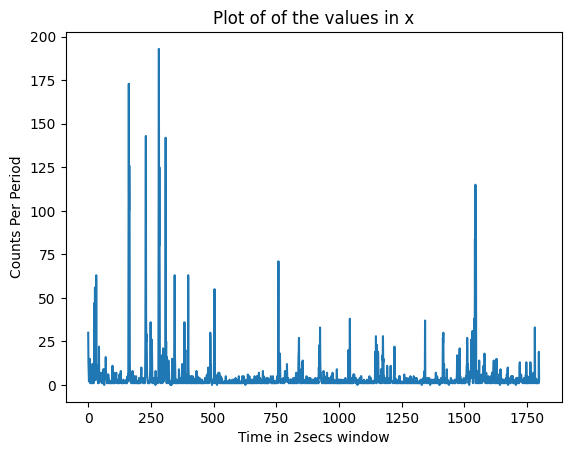

In [112]:
# Plot the values in x
plt.title('Plot of of the values in x')
plt.plot(x)
plt.xlabel(xlabel='Time in 2secs window')
plt.ylabel(ylabel='Counts Per Period')
plt.show()

In [113]:
# Definitely from above we can see some spikes
# This suggest some 2 seconds period have a large amount of counts

# Get the Fourier Transform of the signal
# Notice the result is a complex number, consisting of the real and imaginary component
fourier = np.fft.fft(x)
fourier, len(fourier)

(array([ 8216.           +0.j        ,  1913.98722741 -956.73902893j,
           18.18684807-1246.50554465j, ..., -1694.41853886 +611.36477164j,
           18.18684807+1246.50554465j,  1913.98722741 +956.73902893j]),
 1800)

C:\Users\SecurityNik\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning:

Casting complex values to real discards the imaginary part



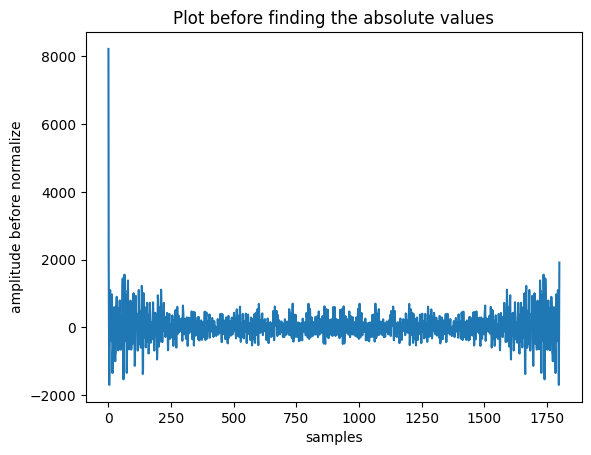

In [114]:
# Plot the values as is before finding the absolute values
# Even though we used Fourier Transform, the x axis is still the number of samples rather than the frequency
# This can be confirmed by the 1800 of the x axis. 
# Notice above, there is 1800 at the bottom of the cell
plt.title(label='Plot before finding the absolute values')
plt.plot(fourier)
plt.xlabel(xlabel='samples')
plt.ylabel(ylabel='amplitude before normalize')
plt.show()

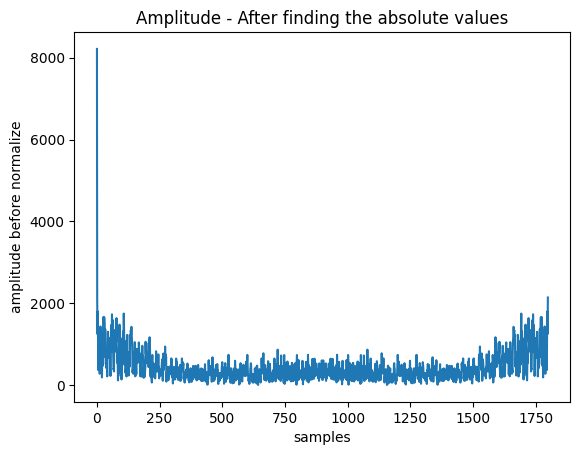

In [115]:
# Plot the values as is after finding the absolute values
# We can see the symmetry in both the graph below and the one above
# Even though we used Fourier Transform, the x axis is still the number of samples rather than the frequency
plt.title(label='Amplitude - After finding the absolute values')
plt.plot(np.abs(fourier))
plt.xlabel(xlabel='samples')
plt.ylabel(ylabel='amplitude before normalize')
plt.show()

In [116]:
# Let's normalize the FFT output
# Remember, Shannon Nyquist states if we sample a signal at a rate of at least 2 times the highest frequency, 
# the analog signal can be recovered perfectly

N = len(x)
normalize = N/2

# At the same time, setup the sampling period
# These logs are for an hour 01:00 to 01:59
# I am keeping this because my original log was for that period
# When we resampled the data above by 2 seconds, it returned 1800
sampling_period = 3600

# Print out the values
len(x), N, normalize, sampling_period

(1800, 1800, 900.0, 3600)

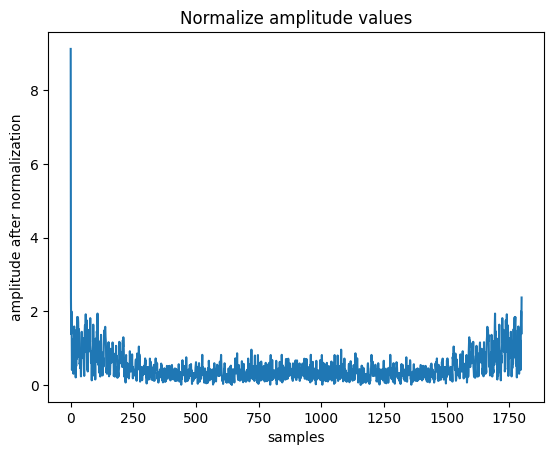

In [117]:
# Plot the absolute value of the amplitude
plt.title(label='Normalize amplitude values')
plt.plot(np.abs(fourier)/normalize)
plt.xlabel(xlabel='samples')
plt.ylabel(ylabel='amplitude after normalization')
plt.show()

In [118]:
# Need to fix the frequency
# We are sampling at every one second in the hour
# This is where I am using the 3600 rather than the 1800 
frequency_rate = 1./sampling_period
frequency_rate

0.0002777777777777778

In [119]:
# Get the frequency axis
frequency_axis = np.fft.fftfreq(n=N, d=frequency_rate)
frequency_axis, len(frequency_axis)

(array([ 0.,  2.,  4., ..., -6., -4., -2.]), 1800)

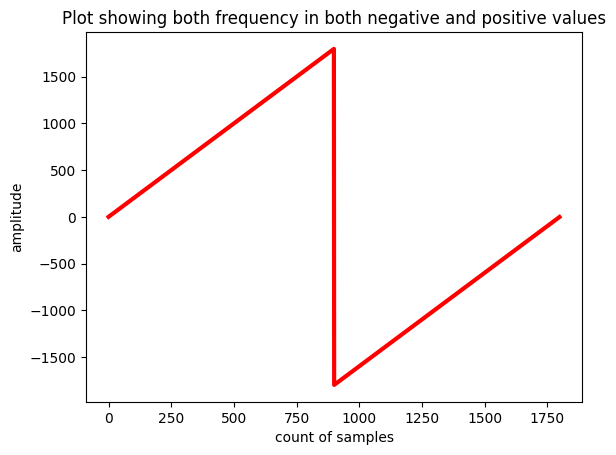

In [120]:
# With the frequency axis in place, let's plot the frequency axis on its own for now
# Notice the Y axis is both positive and negative
# Notice it goes from 0 to 1800 which is half of 3600 which is basically half our sampling period
# Also notice it goes from 0 to -1800
# Notice the symmetry?
plt.title('Plot showing both frequency in both negative and positive values')
plt.plot(frequency_axis, lw=3, c='r')
plt.ylabel('amplitude')
plt.xlabel('count of samples');

Text(0.5, 0, 'Frequencies')

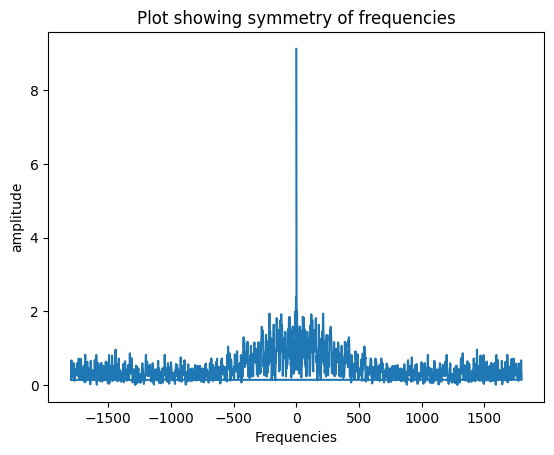

In [121]:
# Looking at the symmetry from another way
# With the frequency axis in place, let's plot the frequency axis on its own for now
# Notice the Y axis is both positive and negative
# Notice it goes from 0 to 1800 which is half of 3600 which is basically half our sampling period
# Also notice it goes from 0 to -1800
# Notice the symmetry?
# Basically same as you saw above. Just from a different perspective
norm_amplitude = np.abs(fourier)/normalize
plt.title('Plot showing symmetry of frequencies')
plt.plot(frequency_axis, norm_amplitude)
plt.ylabel('amplitude')
plt.xlabel('Frequencies')

In [122]:
# Just print the length and frequency values as a refresher for me
N, frequency_rate

(1800, 0.0002777777777777778)

In [123]:
# Just getting a better understanding of the lengths
len(np.fft.rfft(x)), len(2*np.abs(np.fft.rfft(x))), len(np.abs(np.fft.rfft(x))), N

(901, 901, 901, 1800)

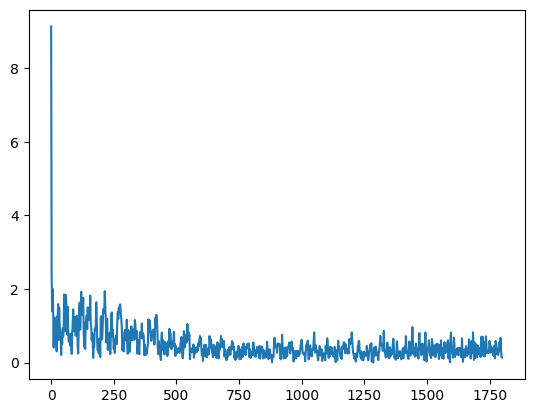

In [124]:
# Finalize this code
# We see that we have also gotten rid of the symmetry
# We now only have the positive half on the line
plt.plot(np.fft.rfftfreq(n=N, d=frequency_rate),  2*np.abs(np.fft.rfft(x))/N)

In [125]:
# Compute the fft values returned for the counts per second
# Use the sampling period of 3600
fft = abs(np.fft.rfft(counts_per_period))
dvalue = int(best_period.rstrip("s")) 
frequencies = np.fft.rfftfreq(n=len(counts_per_period), d=dvalue/sampling_period)

# Print the first 10 entries
frequencies[:10]

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [141]:
# Get any signal spikes over CONST * stdev over the rest of the noise.  This will be the interesting stuff to look
# at.  The amplitudes (y-values) come from the fft array found above.
# Find the standard deviation of the remaining data, so we can use it to find the strongest signals present.  
# Strip off the first 10% of the frequencies found, which will remove the DC component of the signal, leaving you with 
# just the actual signal spikes.

print(f'Max frequency: {max(frequencies)}')
print(f'10% of the max frequency value: {0.1*max(frequencies)}')
print(f'Here are the frequencies - the lower 10%: \n\t {frequencies[frequencies > 0.1*max(frequencies)][:10]}')

Max frequency: 900.0
10% of the max frequency value: 90.0
Here are the frequencies - the lower 10%: 
	 [ 91.  92.  93.  94.  95.  96.  97.  98.  99. 100.]


In [127]:
# With the above being made clear, save these new frequencies to a variable
stripped_frequencies = frequencies[ frequencies > 0.1 * max(frequencies) ]

# Print the first 10 entries
stripped_frequencies[:10]

array([ 91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])

In [128]:
print(f'[*] Size of stripped frequencies: {stripped_frequencies.size}')
print(f'[*] Length of the fft transformed data: {len(fft)}')
print(f'[*] New FFT:  {fft[len(fft) - stripped_frequencies.size:][:10]}')

[*] Size of stripped frequencies: 810
[*] Length of the fft transformed data: 901
[*] New FFT:  [1143.47208739  473.94896724  304.70114392  420.31706819  219.34075832
  581.26586592  572.50777759  136.43847641 1108.424958   1136.18872268]


In [129]:
# Get the stripped FFT
stripped_fft = fft[len(fft) - stripped_frequencies.size:]

# Print the first 10 entries
stripped_fft[:10]

array([1143.47208739,  473.94896724,  304.70114392,  420.31706819,
        219.34075832,  581.26586592,  572.50777759,  136.43847641,
       1108.424958  , 1136.18872268])

In [130]:
# Leverage descriptive statistics 
# Get the standard deviation
std_dev = np.std(stripped_fft)

# Get the mean
mean = np.mean(stripped_fft)

# Set a threshold
threshold = mean + 2*std_dev

print(f'Standard Deviation: {std_dev} | Mean: {mean} | Threshold: {threshold}')

Standard Deviation: 240.6914745391128 | Mean: 369.67931016529883 | Threshold: 851.0622592435244


In [131]:
# Add the strong signals to a list
strong_signals = []
for signal in stripped_fft:
    if (signal > threshold): 
        # print(f"adding signal: {str(signal)}")
        strong_signals.append(signal)

# Print the first 10 entries
strong_signals[:10]


[1143.4720873935075,
 1108.4249580037538,
 1136.188722679384,
 978.1350685678566,
 1309.8618870200787,
 1265.7223903589352,
 1214.0629560494137,
 1747.6746509763254,
 1440.277194109987,
 1079.5542043630226]

In [142]:
# Plot the frequency data after removing the DC component
fig = px.line(
    x=stripped_frequencies,
    y=(abs(stripped_fft)),
    labels=dict(x="Frequency (cycle/sec)", y="Connection Information"),
    title="Connection Information by Frequency With DC Offset Removed; Sampling Period: " + best_period
)
fig.show()

In [133]:
# For each strong signal: find the array index from the fft array
signal_indices = []
i = 0
while (i < len(strong_signals)):
    matching_index = np.where(fft == np.float64(strong_signals[i]))[0][0]
    #print(f'Matching Index: {matching_index}')
    signal_indices.append(matching_index)
    i += 1

signal_indices[:10]

[91, 99, 100, 103, 104, 105, 106, 107, 108, 109]

In [134]:
# Create a new array of the same size as the fft array.  Zero it out,
# except for the indices you just found, which are the strong signals we
# want to find the times for.
strong_signal_frequencies = np.zeros(len(fft))
for index in signal_indices:
    strong_signal_frequencies[index] = frequencies[index]
    
strong_signal_amplitudes = np.zeros(len(fft))
for index in signal_indices:
    strong_signal_amplitudes[index] = fft[index]

In [135]:
# Graph the data in the time domain, by your 2 seconds sampling period
# Clearly we can see below there spikes of interest
fig = px.line(
    counts_per_period,
    labels=dict(x="Timestamp", y="DNS Log Information"),
    title="DNS By Timestamp; Sampling Period: " + best_period
)
fig.show()

In [136]:
# De-noise the data by filtering. Make an effective bandpass filter by
# zeroing out all the frequencies except the strong ones found above.
# Plot just the strong signal frequencies vs their amplitudes.
fig = px.line(
    x=frequencies,
    y=(abs(strong_signal_amplitudes)),
    labels=dict(x="Frequency (cycle/sec)", y="DNS Requests"),
        title="Strongest Signal Frequencies; Sampling Period: " + best_period
)
fig.update_yaxes(
    range=(0, 1.5*max(strong_signal_amplitudes)),
    constrain='domain'
)
fig.update_xaxes(
    
)
fig.show()

In [137]:
# Use the Inverse FFT to flip just the strong signals back to time-domain
inverse_fft = np.fft.irfft(strong_signal_amplitudes, len(counts_per_period))

fig = px.line(
    x=counts_per_period.to_frame().index,
    y=inverse_fft,
    labels=dict(x="Timestamp", y="DNS Log"),
        title="Periodic Signal"
)

fig.show()

In [138]:
# OK.  Now, for each of our strong signals, we need to identify domains from our original data set that 
# had a count of DNS requests "near" our signal strengths.  (It won't be spot-on, due to sample frequency 
# bin width and signal jitter.)  This will be the shortlist of IP for further investigation.
shortlist = []
newdf = df_dns.groupby(['id.orig_h']).size().reset_index(name='counts')
for amplitude in strong_signals:
    shortlist.append(newdf[ (newdf['counts'] > (amplitude*0.8)) & (newdf['counts'] < (amplitude*1.2)) ])
    
results = pd.concat(shortlist, ignore_index=True)
#print(results)
results[['id.orig_h','counts']]

,id.orig_h,counts
0,10.0.0.24,1927
1,10.0.0.9,1770


In [139]:
# Just as we expected, this started off with us recognizing via tcpdump that the host is at 10.0.0.24,
# is sending beacons every two seconds
# Not only are we able to find that host but we also are seeing another host that is exhibiting similar behaviour
# Let's now go back into our dataframe and isolate traffic from these two hosts
df_dns[(df_dns['id.orig_h'] == '10.0.0.9') | (df_dns['id.orig_h'] == '10.0.0.24') ]

,ts,id.orig_h,id.orig_p,id.resp_h,query
21,2023-10-01 01:00:00,10.0.0.9,40520,10.0.0.2,somedomain.securitynik.local
28,2023-10-01 01:00:00,10.0.0.24,41626,10.0.0.2,assets-sncust.securitynik.com
29,2023-10-01 01:00:00,10.0.0.24,39327,10.0.0.2,assets-sncust.securitynik.com
35,2023-10-01 01:00:02,10.0.0.9,33415,10.0.0.2,somedomain.securitynik.local
37,2023-10-01 01:00:03,10.0.0.24,61312,10.0.0.2,s.update.3lift.com
...,...,...,...,...,...
8194,2023-10-01 01:59:45,10.0.0.24,5353,224.0.0.251,_googlecast._tcp.local
8209,2023-10-01 01:59:56,10.0.0.9,55148,10.0.0.2,somedomain.securitynik.local
8214,2023-10-01 01:59:58,10.0.0.9,40965,10.0.0.2,somedomain.securitynik.local
8215,2023-10-01 01:59:59,10.0.0.24,36625,10.0.0.2,i.ytimg.com


In [140]:
# At this point, we can convert this notebook to a python script that we can run in our environment
# See you in an upcoming SEC595: Applied Data Science and AI/Machine Learning for Cybersecurity Professionals
# Also once again, big thanks to Joe Petroske for doing the initial heavy lifting.

In [ ]:
# Some other helpful links
'''
https://realpython.com/python-scipy-fft/
https://towardsdatascience.com/fourier-transform-the-practical-python-implementation-acdd32f1b96a
https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.00-Fourier-Transforms.html

https://ocw.mit.edu/courses/6-003-signals-and-systems-fall-2011/12e6e5d7567fca2e993ef8563fef5a60_MIT6_003F11_lec21.pdf
https://dsp.stackexchange.com/questions/30552/sampling-rate-vs-sampling-time-of-fft
https://electronics.stackexchange.com/questions/12407/what-is-the-relation-between-fft-length-and-frequency-resolution
https://eeweb.engineering.nyu.edu/~yao/EE3054/Ch12.3_sampling.pdf
https://www.eecs.umich.edu/courses/eecs206/archive/f02/public/lec/lect20.pdf

'''